# Práctica 2: Clasificación multi-intancia
### Objetivo: El objetivo de esta práctica es introducir los conceptos de clasificación multi-instancia
### Carlos Checa Moreno
### i02chmoc@uco.es
Google Colab: https://colab.research.google.com/drive/1eWArpDp-uSWyR6KY1nMKwbjZlSnXhdio?usp=sharing

 # OPCIÓN 2: Comparación de métodos
 Seleccione al menos dos algoritmos de los disponibles en la bibliotecas indicadas. Seleccione al menos tres problemas
de multi-instancia de los repositorios indicados.
 Realice las siguientes tareas:
 1. Aplique los algoritmos seleccionados a los datasets
 2. Compare los resultados y explique qué conclusiones se podrían obtene

# Solución opción 2

Entre las diferentes librerías de multi-instance learning con Python he decidido realizar esta práctica con el repositorio: **MILpy: Multiple-Instance Learning Python Toolbox** (https://github.com/jmarrietar/MILpy).
También he probado MISVM (https://github.com/garydoranjr/misvm) y MIL: multiple instance learning library for Python (https://github.com/rosasalberto/mil), pero para ambos casos obtenía multiples problemas con las versiones de las librerías. Por lo tanto, decidí usar MILpy que era la alternativa que menos problemas me ha dado.

En MILpy podemos encontrar los siguientes algoritmos: BOW, CKNN, EMDD, MILBoost, MILES y simpleMIL. De entre todos estos he elegido comparar **simpleMIL** y **CKNN** porque prácticamente todos los demás me daban problemas con la versión de python y demás librerías (hay que tener en cuenta que el repositorio tiene 9 años).


## Preparación librería

In [ ]:
# Obtenemos la librería MILpy
!git clone https://github.com/jmarrietar/MILpy.git

Cloning into 'MILpy'...



Sin embargo, en simpleMIL también tendremos un pequeño par de errores. Primero en su código tiene unos *print* sin paréntesis. Simplemente accederemos a /MILpy/Algorithms/simpleMIL.py y pondremos paréntesis a los mensajes de los prints que no tengan. Con el siguiente código se puede corregir este primer error:

In [ ]:
try:
    with open('C:/Users/Usuario/OneDrive/Master/CNC/Practica2Multiinstancia/MILpy/Algorithms/simpleMIL.py', 'r+') as file: # ruta para Google Colab: /content/MILpy
            lines = file.readlines()
            lines[42] = lines[42].replace("'No exist'", "('No exist')")
            lines[68] = lines[68].replace("'No exist'", "('No exist')")
            file.seek(0)
            file.writelines(lines)
    print("La líneas han sido modificadas correctamente.")
except Exception as e:
    print(f"Se ha producido un error inesperado: {e}")

La líneas han sido modificadas correctamente.


A continuación, es necesario corregir un par de errores para load_data. Tendremos que acceder a /MILpy/data/load_data.py y en la línea 28 que es "filename_labels = 'data/'+file+'/bagI.mat'" poner la b de bag mayúscula para que coincida con como han sido nombrado todos los datasets. De tal forma que nos quedaríamos con "filename_labels = 'data/'+file+'/BagI.mat'". Los mismo para "'/content/MILpy/data/__init__.py'" y cambiar 'from load_data import load_data' por 'from MILpy.data import load_data'.

Con el siguiente código se puede cambiar directamente:

In [ ]:
try:
    with open('/content/MILpy/data/load_data.py', 'r+') as file: # ruta para Google Colab
        lines = file.readlines()
        lines[27] = lines[27].replace('bagI.mat', 'BagI.mat')
        file.seek(0)
        file.writelines(lines)
    print("La línea ha sido modificada correctamente.")
except Exception as e:
    print(f"Se ha producido un error inesperado: {e}")

try:
    with open('/content/MILpy/data/__init__.py', 'r+') as file: # ruta para Google Colab
        lines = file.readlines()
        lines[6] = lines[6].replace('from load_data import load_data', 'from MILpy.data import load_data')
        file.seek(0)
        file.writelines(lines)
    print("La línea ha sido modificada correctamente.")
except Exception as e:
    print(f"Se ha producido un error inesperado: {e}")

La línea ha sido modificada correctamente.
La línea ha sido modificada correctamente.


In [ ]:
import sys,os
# os.chdir('/content/MILpy/') # ruta para Google Colab
os.chdir('C:/Users/Usuario/OneDrive/Master/CNC/Practica2Multiinstancia/MILpy')
sys.path.append(os.path.realpath('..'))
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import timeit
import matplotlib.pyplot as plt
from MILpy.Algorithms.simpleMIL import simpleMIL # Hay que cambiar el print 'No exist' y añadirle los correspondientes paréntesis
from MILpy.Algorithms.CKNN import CKNN
from MILpy.data.load_data import load_data
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Datasets

Usaré los datasets que nos ofrece MILpy, los cuales son los siguientes:

In [ ]:
'''--------- Lista de nombres de los datasets ---------'''
datasets = [
    'tiger_scaled',
    'birds_BRCR_scaled',
    'elephant_scaled',
    'fox_scaled',
    'musk1_scaled',
    'musk2_scaled',
    'mutagenesis1_scaled',
    'mutagenesis2_scaled'
]

### Funciones para evaluación de algoritmos

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

'''--------- Calcular métricas ---------'''
def calculate_metrics(test_labels, predictions, elapsed_time):
    accuracy = np.average(test_labels.T == np.sign(predictions))
    precision = precision_score(test_labels, np.sign(predictions))
    recall = recall_score(test_labels, np.sign(predictions))
    f1_score = metrics.f1_score(test_labels, np.sign(predictions))

    conf_matrix = metrics.confusion_matrix(test_labels, np.sign(predictions))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'conf_matrix': conf_matrix,
        'time': elapsed_time
    }

'''--------- Print métricas ---------'''
def print_metrics(dataset_name, algorithm_name, results, ax):
    print(f"{algorithm_name} con dataset {dataset_name}:")
    print(f"-  Accuracy: {results['accuracy']:.4f}")
    print(f"-  Precisión: {results['precision']:.4f}")
    print(f"-  Recall: {results['recall']:.4f}")
    print(f"-  F1 Score: {results['f1_score']:.4f}")
    minutes = int(results['time'] // 60)
    seconds = results['time'] % 60
    print(f"-  Tiempo de ejecución: {minutes} minutos : {seconds:.2f} segundos\n")
    print("\n")

    # Visualización de la matriz de confusión usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=results['conf_matrix'])
    disp.plot(ax=ax)
    ax.set_title(f"{dataset_name} - {algorithm_name}")

### Clasificadores

Como se comento al principio, usaré SimpleMIL y CKNN. SimpleMIL considera el promedio de las instancias dentro de cada bolsa para hacer la clasificación, mientras que CKNN es una variante del algoritmo k-NN que clasifica bolsas basándose en sus vecinos más cercanos y en las bolsas que las citan, usando un número fijo de referencias y citaciones para mejorar la precisión. Ambos algoritmos entrenan un modelo con bolsas de entrenamiento y etiquetas, luego hacen predicciones sobre las bolsas de prueba.

In [ ]:
'''--------- SimpleMIL ---------'''
def run_simpleMIL(train_bags, train_labels, test_bags, test_labels):
    start_time = timeit.default_timer()
    model = simpleMIL()
    model.fit(train_bags, train_labels, type='average')
    predictions = model.predict(test_bags)
    elapsed_time = timeit.default_timer() - start_time
    return calculate_metrics(test_labels, predictions, elapsed_time)

'''--------- CKNN ---------'''
def run_CKNN(train_bags, train_labels, test_bags, test_labels):
    start_time = timeit.default_timer()
    model = CKNN()
    model.fit(train_bags, train_labels, references=5, citers=10)
    predictions = model.predict(test_bags)
    elapsed_time = timeit.default_timer() - start_time
    return calculate_metrics(test_labels, predictions, elapsed_time)

SimpleMIL con dataset tiger_scaled:
-  Accuracy: 0.7833
-  Precisión: 0.7692
-  Recall: 0.7407
-  F1 Score: 0.7547
-  Tiempo de ejecución: 0 minutos : 0.01 segundos



CKNN con dataset tiger_scaled:
-  Accuracy: 0.7667
-  Precisión: 0.7600
-  Recall: 0.7037
-  F1 Score: 0.7308
-  Tiempo de ejecución: 0 minutos : 12.48 segundos



SimpleMIL con dataset birds_BRCR_scaled:
-  Accuracy: 0.8364
-  Precisión: 0.7714
-  Recall: 0.8308
-  F1 Score: 0.8000
-  Tiempo de ejecución: 0 minutos : 0.01 segundos



CKNN con dataset birds_BRCR_scaled:
-  Accuracy: 0.6970
-  Precisión: 0.6596
-  Recall: 0.4769
-  F1 Score: 0.5536
-  Tiempo de ejecución: 15 minutos : 52.91 segundos



SimpleMIL con dataset corel_african_scaled:
-  Accuracy: 0.9467
-  Precisión: 0.0000
-  Recall: 0.0000
-  F1 Score: 0.0000
-  Tiempo de ejecución: 0 minutos : 0.03 segundos





c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CKNN con dataset corel_african_scaled:
-  Accuracy: 0.9450
-  Precisión: 0.4615
-  Recall: 0.1875
-  F1 Score: 0.2667
-  Tiempo de ejecución: 11 minutos : 51.03 segundos



SimpleMIL con dataset elephant_scaled:
-  Accuracy: 0.7833
-  Precisión: 0.7188
-  Recall: 0.8519
-  F1 Score: 0.7797
-  Tiempo de ejecución: 0 minutos : 0.01 segundos



CKNN con dataset elephant_scaled:
-  Accuracy: 0.7667
-  Precisión: 0.6970
-  Recall: 0.8519
-  F1 Score: 0.7667
-  Tiempo de ejecución: 0 minutos : 15.70 segundos



SimpleMIL con dataset fox_scaled:
-  Accuracy: 0.6000
-  Precisión: 0.5319
-  Recall: 0.9259
-  F1 Score: 0.6757
-  Tiempo de ejecución: 0 minutos : 0.01 segundos



CKNN con dataset fox_scaled:
-  Accuracy: 0.7167
-  Precisión: 0.7083
-  Recall: 0.6296
-  F1 Score: 0.6667
-  Tiempo de ejecución: 0 minutos : 14.12 segundos



SimpleMIL con dataset musk1_scaled:
-  Accuracy: 0.7500
-  Precisión: 0.6471
-  Recall: 0.9167
-  F1 Score: 0.7586
-  Tiempo de ejecución: 0 minutos : 0.00 segun

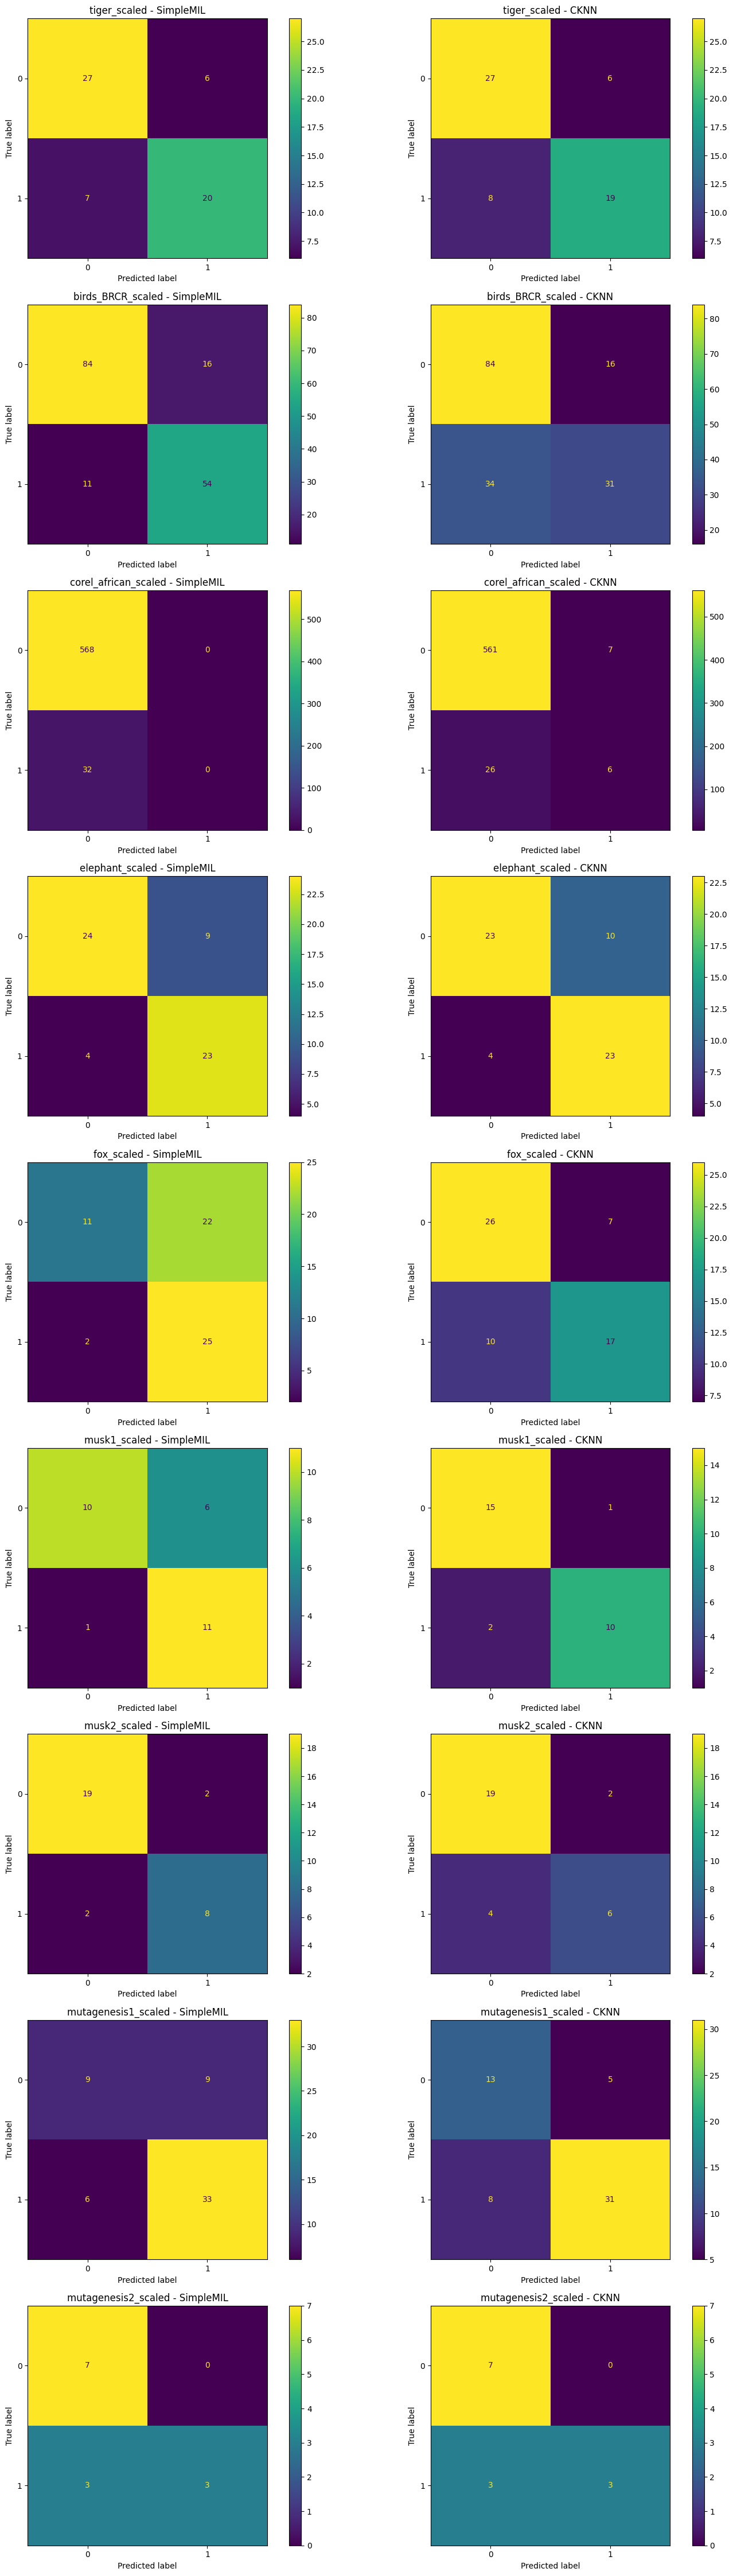

In [ ]:
# Crear una figura y ejes para las subplots
fig, axes = plt.subplots(nrows=len(datasets), ncols=2, figsize=(15, len(datasets) * 5))

for i, dataset_name in enumerate(datasets):
    bags, labels, X = load_data(dataset_name)
    test_size = 0.3
    random_state = 38
    train_bags, test_bags, train_labels, test_labels = train_test_split(bags, labels, test_size=test_size, random_state=random_state)

    simpleMIL_results = run_simpleMIL(train_bags, train_labels, test_bags, test_labels)
    print_metrics(dataset_name, "SimpleMIL", simpleMIL_results, axes[i, 0])

    cknn_results = run_CKNN(train_bags, train_labels, test_bags, test_labels)
    print_metrics(dataset_name, "CKNN", cknn_results, axes[i, 1])

plt.tight_layout()
plt.show()

### Intepretación resultados

En términos de tiempo de ejecución, la diferencia entre ambos métodos es evidente y muy a tener en cuenta. SimpleMIL es muy rápido, procesando cada dataset en fracciones de segundo, mientras que CKNN requiere tiempos considerablemente mayores, llegando hasta 18 minutos en algunos casos, mientras que se están usando datasets bastantes pequeños. Esto hace que SimpleMIL sea una opción mucho más eficiente en escenarios donde la velocidad es crucial.

Respecto a la calidad de la clasificación, se pueden identificar tres tendencias principales:

*   Casos donde SimpleMIL supera a CKNN: En datasets como birds_BRCR_scaled, elephant_scaled y musk2_scaled, SimpleMIL obtiene un mejor equilibrio entre Precisión y Recall, logrando un desempeño más consistente. Por ejemplo, en birds_BRCR_scaled, SimpleMIL alcanza un 83.64% de Accuracy, mientras que CKNN apenas llega al 69.70%, con un Recall significativamente menor, lo que indica una mayor cantidad de falsos negativos.

*   Casos donde CKNN obtiene mejores resultados: En musk1_scaled, CKNN muestra un desempeño claramente superior, alcanzando un Accuracy de 89.29%, mientras que SimpleMIL se queda en 75.00%. Aquí, CKNN logra capturar mejor la distribución de las clases, reflejado también en su mejor F1-Score.

*   Casos donde ambos algoritmos presentan limitaciones: En corel_african_scaled, ambos clasificadores logran Accuracy superiores al 94%, pero SimpleMIL muestra dificultades al clasificar la clase 1, quedándose con una Precisión y Recall de 0.00, mientras que CKNN sí logra capturar parte de los casos positivos, aunque con una calidad moderada (F1-Score de 0.26).

*   Un caso particular es el dataset fox_scaled, donde CKNN obtiene mejor Accuracy (71.67% vs 60.00%), pero SimpleMIL logra un Recall significativamente mayor (92.59%), lo que indica que es más efectivo para detectar los casos positivos, aunque al costo de generar más falsos positivos. Esto puede ser crucial dependiendo del problema a resolver; por ejemplo, en aplicaciones donde evitar falsos negativos es más importante, SimpleMIL sería la mejor opción.

En conclusión, SimpleMIL se destaca por su velocidad y estabilidad en la mayoría de los casos, mientras que CKNN ofrece ventajas en algunos datasets, aunque con un alto costo computacional. Para escenarios donde se prioriza rapidez y un desempeño equilibrado, SimpleMIL es la mejor alternativa. Sin embargo, si se busca una mayor precisión en ciertos conjuntos de datos específicos y se dispone del tiempo de cómputo necesario, CKNN podría ser una opción viable.

<table border="1">
    <tr>
        <th>Algoritmo</th>
        <th>Dataset</th>
        <th>Accuracy</th>
        <th>Precisión</th>
        <th>Recall</th>
        <th>F1 Score</th>
        <th>Tiempo de ejecución</th>
    </tr>
    <tr><td>SimpleMIL</td><td>tiger_scaled</td><td>0.7833</td><td>0.7692</td><td>0.7407</td><td>0.7547</td><td>0 minutos : 0.01 segundos</td></tr>
    <tr><td>CKNN</td><td>tiger_scaled</td><td>0.7667</td><td>0.7600</td><td>0.7037</td><td>0.7308</td><td>0 minutos : 12.48 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>birds_BRCR_scaled</td><td>0.8364</td><td>0.7714</td><td>0.8308</td><td>0.8000</td><td>0 minutos : 0.01 segundos</td></tr>
    <tr><td>CKNN</td><td>birds_BRCR_scaled</td><td>0.6970</td><td>0.6596</td><td>0.4769</td><td>0.5536</td><td>15 minutos : 52.91 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>corel_african_scaled</td><td>0.9467</td><td>0.0000</td><td>0.0000</td><td>0.0000</td><td>0 minutos : 0.03 segundos</td></tr>
    <tr><td>CKNN</td><td>corel_african_scaled</td><td>0.9450</td><td>0.4615</td><td>0.1875</td><td>0.2667</td><td>11 minutos : 51.03 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>elephant_scaled</td><td>0.7833</td><td>0.7188</td><td>0.8519</td><td>0.7797</td><td>0 minutos : 0.01 segundos</td></tr>
    <tr><td>CKNN</td><td>elephant_scaled</td><td>0.7667</td><td>0.6970</td><td>0.8519</td><td>0.7667</td><td>0 minutos : 15.70 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>fox_scaled</td><td>0.6000</td><td>0.5319</td><td>0.9259</td><td>0.6757</td><td>0 minutos : 0.01 segundos</td></tr>
    <tr><td>CKNN</td><td>fox_scaled</td><td>0.7167</td><td>0.7083</td><td>0.6296</td><td>0.6667</td><td>0 minutos : 14.12 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>musk1_scaled</td><td>0.7500</td><td>0.6471</td><td>0.9167</td><td>0.7586</td><td>0 minutos : 0.00 segundos</td></tr>
    <tr><td>CKNN</td><td>musk1_scaled</td><td>0.8929</td><td>0.9091</td><td>0.8333</td><td>0.8696</td><td>0 minutos : 1.83 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>musk2_scaled</td><td>0.8710</td><td>0.8000</td><td>0.8000</td><td>0.8000</td><td>0 minutos : 0.00 segundos</td></tr>
    <tr><td>CKNN</td><td>musk2_scaled</td><td>0.8065</td><td>0.7500</td><td>0.6000</td><td>0.6667</td><td>8 minutos : 15.76 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>mutagenesis1_scaled</td><td>0.7368</td><td>0.7857</td><td>0.8462</td><td>0.8148</td><td>0 minutos : 0.01 segundos</td></tr>
    <tr><td>CKNN</td><td>mutagenesis1_scaled</td><td>0.7719</td><td>0.8611</td><td>0.7949</td><td>0.8267</td><td>18 minutos : 28.65 segundos</td></tr>
    <tr><td>SimpleMIL</td><td>mutagenesis2_scaled</td><td>0.7692</td><td>1.0000</td><td>0.5000</td><td>0.6667</td><td>0 minutos : 0.00 segundos</td></tr>
    <tr><td>CKNN</td><td>mutagenesis2_scaled</td><td>0.7692</td><td>1.0000</td><td>0.5000</td><td>0.6667</td><td>0 minutos : 44.43 segundos</td></tr>
</table>


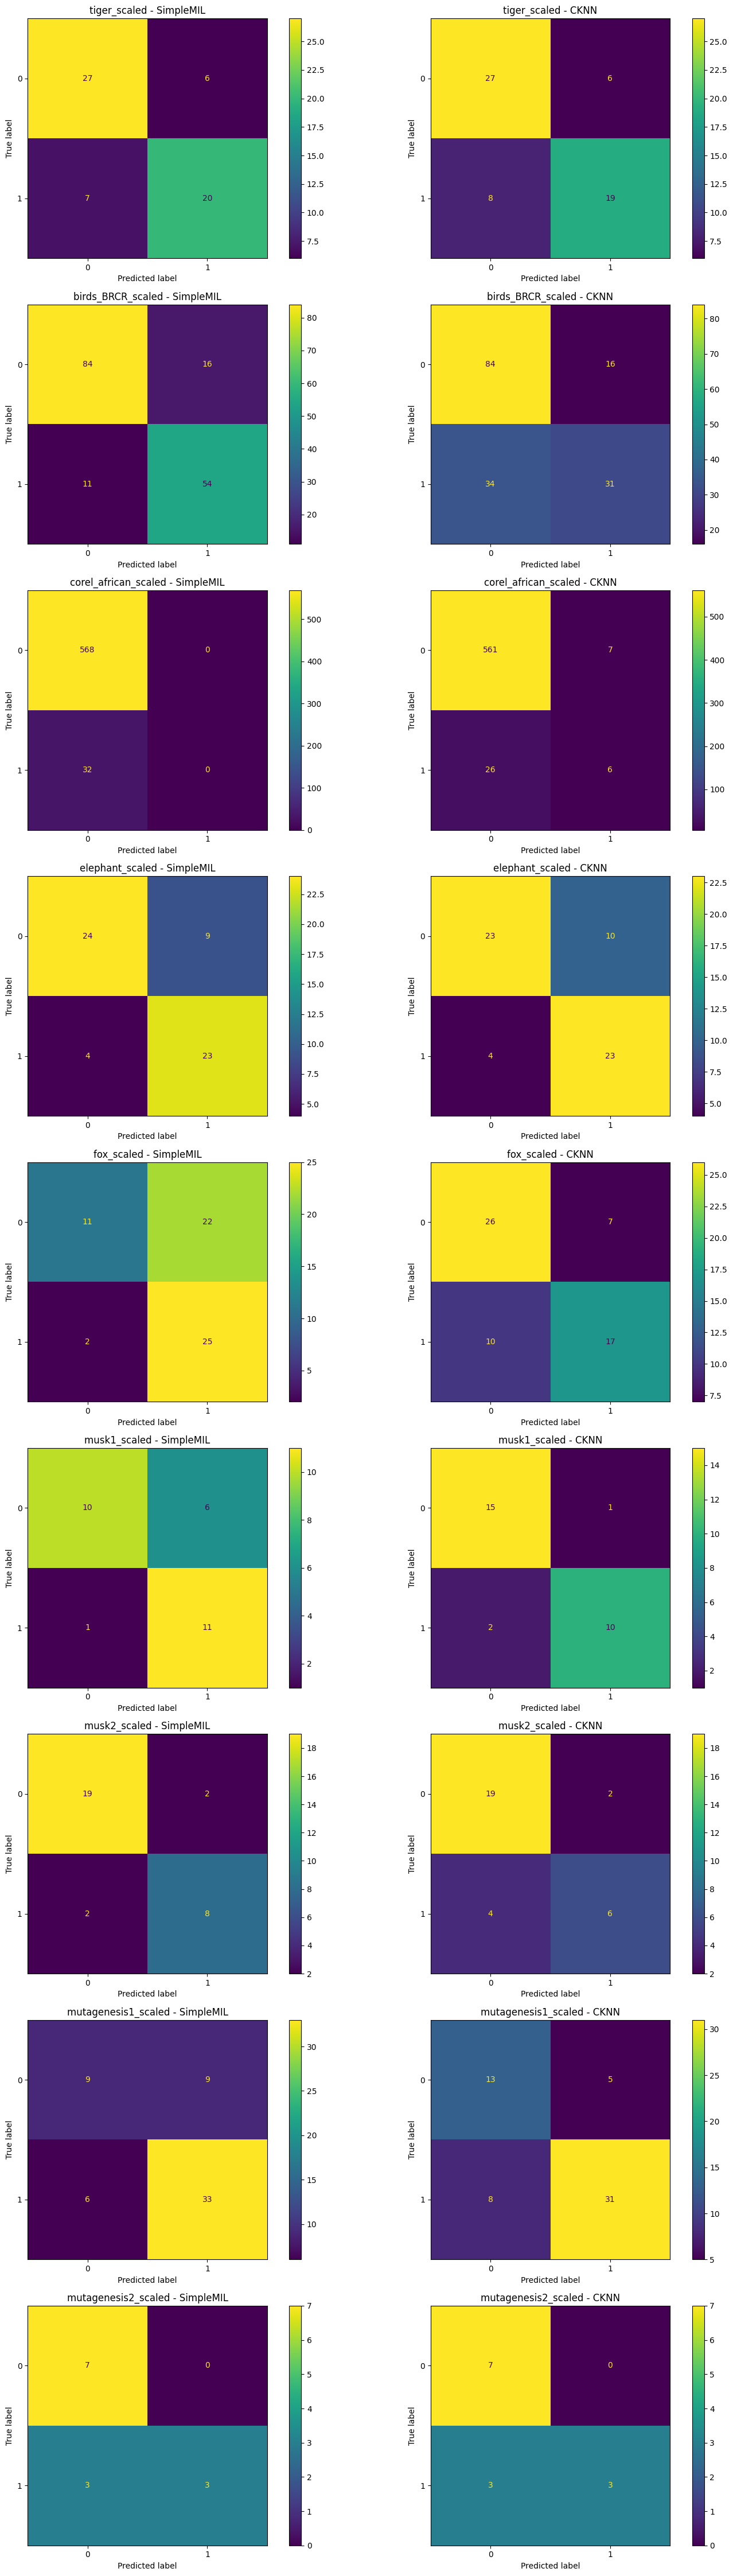